#STT Modelių tyrimas su naudojant nuostolingus, spontaninės kalbos įrašus

In [2]:
!apt-get -y update
!apt-get -y install ffmpeg espeak-ng

!pip -q install \
  "transformers>=4.40.0" accelerate torchaudio librosa \
  jiwer pympi-ling matplotlib tqdm \
  sentence-transformers phonemizer rapidfuzz soundfile pyarrow \
  openai-whisper

import os, re, string, time, gc
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import soundfile as sf
import librosa
import pympi
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from jiwer import process_words, cer
from sentence_transformers import SentenceTransformer
from rapidfuzz.distance import Levenshtein
from phonemizer import phonemize

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,233 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,864 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu

In [3]:
# Load Dataset
from google.colab import drive
drive.mount("/content/drive")

DATA_ROOT = Path("/content/drive/MyDrive/LossySpontaneousDataset")

if not DATA_ROOT.exists():
    raise FileNotFoundError(DATA_ROOT)

rec_dirs = sorted(p for p in DATA_ROOT.iterdir() if p.is_dir())
pairs = [(d.name, d / f"{d.name}.wav", d / f"{d.name}.eaf") for d in rec_dirs] # 3 element touple (rec_id, wav_path, eaf_path)

print("Total recordings:", len(pairs))

# Sanity check
import soundfile as sf

durations = []
for _, wav, _ in pairs:
    info = sf.info(wav)
    durations.append(info.frames / info.samplerate)

print("Duration check (seconds):")
print("Minimum segment duration: ", min(durations), "s")
print("Average segment duration: ", sum(durations)/ len(durations), "s")
print("Maximum segment duration: ", max(durations), "s")
print("Total hours:", sum(durations)/3600)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total recordings: 122
Duration check (seconds):
Minimum segment duration:  74.6 s
Average segment duration:  1409.4852085040982 s
Maximum segment duration:  6793.195125 s
Total hours: 47.765887621527774


In [4]:
# Text Normalization
extra_punct = "„“”–—…"
punct_table = str.maketrans({ch: " " for ch in string.punctuation + extra_punct}) # All punctuation is turned to spaces

NOISE_LABELS = { # Defining labels to be ignored
    "+BREATH+", "+COUGH+", "+LAUGH+", "+SMACK+",
    "+AH+", "+EH+", "+MM+", "+GARBAGE+", "+NOISE+"
}

def normalize_text(s: str) -> str: # all text to lower case, no punctuation, multiple spaces merged, side spaces removed
    s = (s or "").strip().lower()
    s = s.translate(punct_table)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

# metadata from rec_id (L_SD_F4_MS047_01)
rx = re.compile(r'^(?P<lossy>[LR])_(?P<type2>[A-Z]{2})_(?P<gender>[FM])(?P<agegrp>[1-5])_(?P<spk>[A-Z]{2}\d{3})_(?P<sn>\d{2})$')

# metadata map (though not all are present)
LOSSY_MAP  = {"L":"Lossy", "R":"Raw"}
GENDER_MAP = {"F":"Female", "M":"Male"}
AGE_BIN_MAP = {1:"0-12", 2:"13-17", 3:"18-25", 4:"26-60", 5:"60+"}
TYPE2_MAP = {
    "SD": "Dictaphone",
    "ST": "Telephone",
    "SR": "Radio",
    "SS": "Studio",
    "SA": "Audiobook",
    "SP": "Phone",
    "TV": "TV",
    "RD": "Read-Dictaphone",
    "RT": "Read-Telephone",
}

def parse_rec_id(rec_id: str):
    m = rx.match(rec_id or "")
    if not m:
        return {"lossy":"Unknown","type":"Unknown","gender":"Unknown","age_bin":"Unknown"}
    d = m.groupdict()
    ag = int(d["agegrp"])
    return {
        "lossy": LOSSY_MAP.get(d["lossy"], "Unknown"),
        "type": TYPE2_MAP.get(d["type2"], d["type2"]),
        "gender": GENDER_MAP.get(d["gender"], "Unknown"),
        "age_bin": AGE_BIN_MAP.get(ag, "Unknown"),
    }

# pick tier from .eaf
def pick_speech_tier(eaf: pympi.Elan.Eaf):
    tiers = eaf.get_tier_names()
    preferred = ["speech"] # no "noise" segments since it does not have text

    for t in tiers:
        tl = t.lower()
        if "noise" in tl:
            continue
        if any(p in tl for p in preferred):
            return t

In [5]:
# BUILD SEGMENT INDEX
rows = []

for rec_id, wav, eaf in tqdm(pairs, desc="Indexing all segments"):
    eaf_obj = pympi.Elan.Eaf(str(eaf)) # Open .eaf
    tier = pick_speech_tier(eaf_obj) # Select tier
    if tier is None:
        continue

    meta = parse_rec_id(rec_id) # get metadata

    for start_ms, end_ms, value in eaf_obj.get_annotation_data_for_tier(tier): # Get all anotations
        if not value:
            continue
        if value.strip() in NOISE_LABELS:
            continue

        dur_s = (end_ms - start_ms) / 1000.0

        rows.append({
            "rec_id": rec_id,
            "wav": str(wav),
            "start_ms": start_ms,
            "end_ms": end_ms,
            "dur_s": dur_s,
            "ref_raw": value.strip(),
            "ref": normalize_text(value),
            **meta
        })

df_segments = pd.DataFrame(rows)

print("Segments:", len(df_segments))
print("Recordings:", df_segments.rec_id.nunique())
print("Hours:", df_segments.dur_s.sum() / 3600)

display(df_segments.head())

Indexing all segments:   0%|          | 0/122 [00:00<?, ?it/s]

Segments: 48424
Recordings: 122
Hours: 28.412816388888892


,rec_id,wav,start_ms,end_ms,dur_s,ref_raw,ref,lossy,type,gender,age_bin
0,L_SD_F4_IS039_01,/content/drive/MyDrive/LossySpontaneousDataset...,29926,33860,3.934,"turbūt rasite porą čia tik buvo mėnesių, bet a...",turbūt rasite porą čia tik buvo mėnesių bet aš...,Lossy,Dictaphone,Female,26-60
1,L_SD_F4_IS039_01,/content/drive/MyDrive/LossySpontaneousDataset...,34271,36316,2.045,"aš tik generaline, gal porą mėnesių",aš tik generaline gal porą mėnesių,Lossy,Dictaphone,Female,26-60
2,L_SD_F4_IS039_01,/content/drive/MyDrive/LossySpontaneousDataset...,36588,40320,3.732,O šiaip aš visą laiką jau dirbau toj administr...,o šiaip aš visą laiką jau dirbau toj administr...,Lossy,Dictaphone,Female,26-60
3,L_SD_F4_IS039_01,/content/drive/MyDrive/LossySpontaneousDataset...,40673,45310,4.637,generalinio direktoriaus pavaduotoja tai Kviet...,generalinio direktoriaus pavaduotoja tai kviet...,Lossy,Dictaphone,Female,26-60
4,L_SD_F4_IS039_01,/content/drive/MyDrive/LossySpontaneousDataset...,45600,46853,1.253,paskui buvau programų,paskui buvau programų,Lossy,Dictaphone,Female,26-60


In [ ]:
# Helper functions
TARGET_SR = 16000 # 16 kHz

# Join to mono, because stereo is not needed for STT
def load_wav_mono(wav_path: str):
    audio, sr = sf.read(wav_path, always_2d=False)
    if audio.ndim > 1:
        audio = audio.mean(axis=1)
    return audio.astype(np.float32), int(sr)

def cut_segment(audio, sr, start_ms, end_ms, target_sr=16000):
    s = int(start_ms * sr / 1000)
    e = int(end_ms   * sr / 1000)
    seg = audio[s:e].astype(np.float32)
    if len(seg) == 0:
        return None
    if sr != target_sr:
        seg = librosa.resample(seg, orig_sr=sr, target_sr=target_sr).astype(np.float32)
    return seg

In [ ]:
# Define all STT models + load/transcribe functions
from transformers import (
    pipeline, AutoProcessor, AutoModelForSpeechSeq2Seq, AutoModelForCTC, GenerationConfig
)
import whisper as ow

MODELS = [
    dict(
        key="hf_whisper_lt_drishti",
        family="whisper_hf_manual",
        name="HF Whisper LT (Drishti) large-v2",
        id="DrishtiSharma/whisper-large-v2-lithuanian",
        base_gen="openai/whisper-large-v2",
        language="lt",
        task="transcribe",
    ),
    dict(
        key="hf_w2v2_m3hrdadfi",
        family="ctc_hf",
        name="HF Wav2Vec2 LT (m3hrdadfi) XLSR",
        id="m3hrdadfi/wav2vec2-large-xlsr-lithuanian",
    ),
    dict(
        key="hf_w2v2_deividasm",
        family="ctc_hf",
        name="HF Wav2Vec2 LT (DeividasM) XLSR-53",
        id="DeividasM/wav2vec2-large-xlsr-53-lithuanian",
    ),
    dict(
        key="github_whisper_large_v3",
        family="whisper_github",
        name="GitHub Whisper large-v3",
        id="large-v3",
        language="lt",
        task="transcribe",
    ),
]

def make_whisper_hf_manual(model_id, base_gen_id, language="lt", task="transcribe"):
    processor = AutoProcessor.from_pretrained(model_id)
    torch_dtype = torch.float16 if device == "cuda" else torch.float32
    model = AutoModelForSpeechSeq2Seq.from_pretrained(model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True).to(device)
    model.eval()
    model.generation_config = GenerationConfig.from_pretrained(base_gen_id)
    forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task=task)
    return processor, model, forced_decoder_ids

def make_ctc_hf(model_id):
    proc = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForCTC.from_pretrained(model_id).to(device)
    model.eval()
    asr = pipeline("automatic-speech-recognition", model=model, tokenizer=proc.tokenizer, feature_extractor=proc.feature_extractor, device=0 if device == "cuda" else -1,)
    return asr

def make_github_whisper(model_name):
    return ow.load_model(model_name, device=device)

def load_one(cfg):
    fam = cfg["family"]
    if fam == "whisper_hf_manual":
        return make_whisper_hf_manual(cfg["id"], cfg["base_gen"], cfg.get("language","lt"), cfg.get("task","transcribe"))
    if fam == "ctc_hf":
        return make_ctc_hf(cfg["id"])
    if fam == "whisper_github":
        return make_github_whisper(cfg["id"])
    raise ValueError("Unknown family")

@torch.inference_mode()
def transcribe_one(cfg, obj, audio_np):
    fam = cfg["family"]

    if fam == "ctc_hf":
        out = obj(audio_np, sampling_rate=TARGET_SR)
        return out.get("text", "")

    if fam == "whisper_hf_manual":
        processor, model, forced_decoder_ids = obj
        inputs = processor(audio_np, sampling_rate=TARGET_SR, return_tensors="pt")
        model_dtype = next(model.parameters()).dtype
        feats = inputs.input_features.to(device=device, dtype=model_dtype)

        attn = None
        if hasattr(inputs, "attention_mask") and inputs.attention_mask is not None:
            attn = inputs.attention_mask.to(device)

        pred_ids = model.generate(
            feats,
            attention_mask=attn,
            forced_decoder_ids=forced_decoder_ids,
            max_new_tokens=225
        )
        return processor.batch_decode(pred_ids, skip_special_tokens=True)[0]

    if fam == "whisper_github":
        res = obj.transcribe(
            audio_np,
            language=cfg.get("language","lt"),
            task=cfg.get("task","transcribe"),
            fp16=(device == "cuda")
        )
        return res.get("text", "")

    raise ValueError("Unknown family")

def unload():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("Defined models:", [m["key"] for m in MODELS])

Defined models: ['hf_whisper_lt_drishti', 'hf_w2v2_m3hrdadfi', 'hf_w2v2_deividasm', 'github_whisper_large_v3']


In [8]:
# Run transcription for ALL segments (save to Drive, one model at a time)
OUT_DIR = Path("/content/drive/MyDrive/LossySpontaneousDataset_RESULTS")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUT_DIR:", OUT_DIR)

def transcribe_all_segments_for_model(cfg, df_all):
    final_path   = OUT_DIR / f"transcripts_{cfg['key']}.parquet"
    partial_path = OUT_DIR / f"transcripts_{cfg['key']}.partial.parquet"

    # if the model result is there - do nothing
    if final_path.exists():
        print("✅ Already exists:", final_path.name)
        return final_path

    # if crashed - load the partial model result
    done_keys = set()
    if partial_path.exists():
        prev = pd.read_parquet(partial_path, columns=["wav", "start_ms", "end_ms"])
        done_keys = set(zip(
            prev["wav"].astype(str),
            prev["start_ms"].astype(int),
            prev["end_ms"].astype(int),
        ))
        print(f"♻️ Found partial progress: {len(done_keys)} segments already done")

    # skip completed segments
    if done_keys:
        mask = [
            (str(r.wav), int(r.start_ms), int(r.end_ms)) not in done_keys
            for r in df_all.itertuples(index=False)
        ]
        df_todo = df_all.loc[mask].copy()
    else:
        df_todo = df_all

    todo_total = len(df_todo)
    print(f"Will transcribe: {todo_total}/{len(df_all)} segments (missing)")

    # checkpoint every 25% (minimum 5000 segments)
    quarter = max(1, int(todo_total * 0.25))
    CHUNK_SIZE = max(5000, quarter)

    obj = load_one(cfg)
    out_rows = []
    processed = 0

    def flush_chunk(rows_chunk):
        if not rows_chunk:
            return

        chunk_path = OUT_DIR / f"chunk_{cfg['key']}_{int(time.time())}.parquet"
        pd.DataFrame(rows_chunk).to_parquet(chunk_path, index=False)

        # merge chunk -> partial
        if partial_path.exists():
            base = pd.read_parquet(partial_path)
            add  = pd.read_parquet(chunk_path)
            merged = pd.concat([base, add], ignore_index=True)
        else:
            merged = pd.read_parquet(chunk_path)

        merged.to_parquet(partial_path, index=False)
        chunk_path.unlink(missing_ok=True)

    # transcribe (group by wav for efficiency)
    for wav_path, g in tqdm(
        df_todo.groupby("wav", sort=False),
        total=df_todo["wav"].nunique(),
        desc=f"Transcribing: {cfg['name']}"
    ):
        wav_audio, wav_sr = load_wav_mono(wav_path)

        for _, r in g.iterrows():
            seg = cut_segment(wav_audio, wav_sr, int(r.start_ms), int(r.end_ms), target_sr=TARGET_SR)
            hyp_raw = transcribe_one(cfg, obj, seg) if seg is not None else ""

            out_rows.append({
                "model_key": cfg["key"],
                "model": cfg["name"],
                "rec_id": r.rec_id,
                "wav": str(wav_path),
                "start_ms": int(r.start_ms),
                "end_ms": int(r.end_ms),
                "dur_s": float(r.dur_s),
                "ref_raw": r.ref_raw,
                "ref": r.ref,
                "hyp_raw": hyp_raw,
                "hyp": normalize_text(hyp_raw),
                "lossy": r.lossy,
                "type": r.type,
                "gender": r.gender,
                "age_bin": r.age_bin,
            })

            processed += 1

            # Checkpoint
            if processed % CHUNK_SIZE == 0:
                pct = (processed / max(1, todo_total)) * 100
                print(f"\n💾 Checkpoint: {processed}/{todo_total} ({pct:.1f}%)")
                flush_chunk(out_rows)
                out_rows = []

    # final flush
    flush_chunk(out_rows)

    # partial -> final
    if partial_path.exists():
        merged = pd.read_parquet(partial_path)
        merged = merged.drop_duplicates(subset=["wav", "start_ms", "end_ms"], keep="first")
        merged.to_parquet(final_path, index=False)
        partial_path.unlink(missing_ok=True)

    print("✅ Saved final:", final_path.name)

    del obj
    unload()
    return final_path

# Run for all models
paths = []
for cfg in MODELS:
    paths.append(transcribe_all_segments_for_model(cfg, df_segments))

print("Done:")
for p in paths:
    print(" -", p.name)

OUT_DIR: /content/drive/MyDrive/LossySpontaneousDataset_RESULTS
Will transcribe: 48424/48424 segments (missing)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/832 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


pytorch_model.bin:   0%|          | 0.00/6.17G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.17G [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Transcribing: HF Whisper LT (Drishti) large-v2:   0%|          | 0/122 [00:00<?, ?it/s]

Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



💾 Checkpoint: 12106/48424 (25.0%)

💾 Checkpoint: 24212/48424 (50.0%)

💾 Checkpoint: 36318/48424 (75.0%)

💾 Checkpoint: 48424/48424 (100.0%)
✅ Saved final: transcripts_hf_whisper_lt_drishti.parquet
✅ Already exists: transcripts_hf_w2v2_m3hrdadfi.parquet
✅ Already exists: transcripts_hf_w2v2_deividasm.parquet
✅ Already exists: transcripts_github_whisper_large_v3.parquet
Done:
 - transcripts_hf_whisper_lt_drishti.parquet
 - transcripts_hf_w2v2_m3hrdadfi.parquet
 - transcripts_hf_w2v2_deividasm.parquet
 - transcripts_github_whisper_large_v3.parquet


In [9]:
# Keyword Recall (KR)
# KR = (keywords found) / (all keywords)
LT_STOPWORDS = {
    "ir","ar","o","bet","kad","kai","jei","nei","ne","taip","čia","ten","aš","tu","jis","ji","mes","jūs","jie","jos",
    "man","tau","jam","jai","mums","jums","jiems","joms",
    "mano","tavo","jo","jos","mūsų","jūsų","jų",
    "yra","buvo","bus","būti","esu","esi","yra",
    "į","i","su","be","pas","prie","už","ant","po","apie","nuo","iki","per","dėl",
    "kaip","kur","kada","kodėl","nes","tai","tą","tas","ta","tie","tos","šis","ši","šita","šitas","šitie","šitos",
    "labai","vis","visi","visa","visą","daug","mažai","dar","jau","tik","net","na","nu","va"
}

def extract_keywords(text: str, min_len: int = 4, max_keywords: int = 12):
    """
    Iš teksto ištraukia keywordus:
    - split per tarpus
    - meta stopwordus
    - meta trumpus žodžius
    - palieka iki max_keywords (pirmus pagal pasirodymą)
    """
    t = normalize_text(text)
    if not t:
        return []

    words = [w for w in t.split() if len(w) >= min_len and w not in LT_STOPWORDS]
    # unikalūs išlaikant eilę
    seen = set()
    out = []
    for w in words:
        if w not in seen:
            seen.add(w)
            out.append(w)
        if len(out) >= max_keywords:
            break
    return out

def keyword_recall_per(refs, hyps, min_len: int = 4, max_keywords: int = 12):
    """
    Grąžina masyvą KR reikšmių kiekvienam segmentui.
    KR = hits / total_keywords (NaN jei total_keywords==0)
    """
    kr = np.full(len(refs), np.nan, dtype=np.float32)

    for i, (r, h) in enumerate(zip(refs, hyps)):
        kws = extract_keywords(r, min_len=min_len, max_keywords=max_keywords)
        if len(kws) == 0:
            continue

        hyp = normalize_text(h)
        hits = sum(1 for kw in kws if kw in hyp.split())
        kr[i] = hits / len(kws)

    return kr

In [10]:
# Compute metrics per model (WER, CER, SEM, PED, KR) + save "scored_*.parquet"

# Semantic model (sentence embeddings)
SEM_MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
sem_model = SentenceTransformer(SEM_MODEL_NAME, device=device)

def semantic_cosine(refs, hyps, batch_size=128):
    ref_emb = sem_model.encode(refs, batch_size=batch_size, convert_to_numpy=True,
                               show_progress_bar=True, normalize_embeddings=True)
    hyp_emb = sem_model.encode(hyps, batch_size=batch_size, convert_to_numpy=True,
                               show_progress_bar=True, normalize_embeddings=True)
    return (ref_emb * hyp_emb).sum(axis=1).astype(np.float32)

def to_phonemes_lt(texts):
    sep = " ||| "
    try:
        out = phonemize(
            texts,
            language="lt",
            backend="espeak",
            strip=True,
            preserve_punctuation=False,
            with_stress=False,
            njobs=1,
            separator=sep
        )
        if isinstance(out, str):
            parts = out.split(sep)
        else:
            parts = list(out)
        return parts if len(parts) == len(texts) else list(texts)
    except Exception:
        return list(texts)

def phoneme_edit_distance(refs, hyps):
    ref_ph = to_phonemes_lt(refs)
    hyp_ph = to_phonemes_lt(hyps)
    d = np.zeros(len(refs), dtype=np.float32)
    for i, (r, h) in enumerate(zip(ref_ph, hyp_ph)):
        denom = max(1, len(r))
        d[i] = Levenshtein.distance(r, h) / denom
    return d

def detailed_wer(refs, hyps):
    out = process_words(refs, hyps)
    S, D, I, H = out.substitutions, out.deletions, out.insertions, out.hits
    N = H + S + D
    wer = (S + D + I) / max(1, N)
    return float(wer), int(S), int(D), int(I), int(N)

def avg_value(arr):
    arr = np.array(arr, dtype=np.float32)
    return float(np.nanmean(arr))

summary_rows = []

for cfg in MODELS:
    tpath = OUT_DIR / f"transcripts_{cfg['key']}.parquet"
    tdf = pd.read_parquet(tpath)

    if "dur_s" not in tdf.columns:
        if "start_ms" in tdf.columns and "end_ms" in tdf.columns:
            tdf["dur_s"] = (tdf["end_ms"].astype(np.float32) - tdf["start_ms"].astype(np.float32)) / 1000.0
        else:
            tdf["dur_s"] = 0.0


    refs = tdf["ref"].astype(str).tolist()
    hyps = tdf["hyp"].astype(str).tolist()

    wer, sub, dele, ins, Nw = detailed_wer(refs, hyps)
    cer_val = float(cer(refs, hyps))

    print("\n---", cfg["name"], "---")
    print("Computing SEM...")
    sem_per = semantic_cosine(refs, hyps, batch_size=128)

    print("Computing PED...")
    ped_per = phoneme_edit_distance(refs, hyps)

    print("Computing KR...")
    kr_per = keyword_recall_per(refs, hyps)
    kr_cov = float(np.mean(~np.isnan(kr_per))) * 100.0

    # save per-segment metrics
    tdf["SEM"] = sem_per
    tdf["PED"] = ped_per
    tdf["KR"]  = kr_per
    scored_path = OUT_DIR / f"scored_{cfg['key']}.parquet"
    tdf.to_parquet(scored_path, index=False)

    summary_rows.append({
        "model": cfg["name"],
        "key": cfg["key"],
        "segments": len(tdf),
        "hours": float(tdf["dur_s"].sum() / 3600),
        "WER_%": wer * 100,
        "CER_%": cer_val * 100,
        "SEM_avg": avg_value(sem_per),
        "PED_avg": avg_value(ped_per),
        "KR_avg": float(np.nanmean(kr_per)),
        "KR_coverage_%": kr_cov,
        "sub": sub, "del": dele, "ins": ins,
        "N_words": Nw,
    })

sum_df = pd.DataFrame(summary_rows).sort_values("WER_%").reset_index(drop=True)
display(sum_df)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


--- HF Whisper LT (Drishti) large-v2 ---
Computing SEM...


Batches:   0%|          | 0/379 [00:00<?, ?it/s]

Batches:   0%|          | 0/379 [00:00<?, ?it/s]

Computing PED...
Computing KR...

--- HF Wav2Vec2 LT (m3hrdadfi) XLSR ---
Computing SEM...


Batches:   0%|          | 0/379 [00:00<?, ?it/s]

Batches:   0%|          | 0/379 [00:00<?, ?it/s]

Computing PED...
Computing KR...

--- HF Wav2Vec2 LT (DeividasM) XLSR-53 ---
Computing SEM...


Batches:   0%|          | 0/379 [00:00<?, ?it/s]

Batches:   0%|          | 0/379 [00:00<?, ?it/s]

Computing PED...
Computing KR...

--- GitHub Whisper large-v3 ---
Computing SEM...


Batches:   0%|          | 0/379 [00:00<?, ?it/s]

Batches:   0%|          | 0/379 [00:00<?, ?it/s]

Computing PED...
Computing KR...


,model,key,segments,hours,WER_%,CER_%,SEM_avg,PED_avg,KR_avg,KR_coverage_%,sub,del,ins,N_words
0,GitHub Whisper large-v3,github_whisper_large_v3,48424,28.412816,40.872292,16.340466,0.842444,0.210492,0.514875,92.5698,71714,14464,7422,229006
1,HF Whisper LT (Drishti) large-v2,hf_whisper_lt_drishti,48424,28.412816,45.493131,16.001993,0.849219,0.246846,0.536723,92.5698,78494,18445,7243,229006
2,HF Wav2Vec2 LT (m3hrdadfi) XLSR,hf_w2v2_m3hrdadfi,48424,28.412816,75.636010,24.209581,0.701915,0.271933,0.267939,92.5698,131117,36221,5873,229006
3,HF Wav2Vec2 LT (DeividasM) XLSR-53,hf_w2v2_deividasm,48424,28.412816,80.379990,25.582654,0.673118,0.271189,0.211096,92.5698,143966,31852,8257,229006


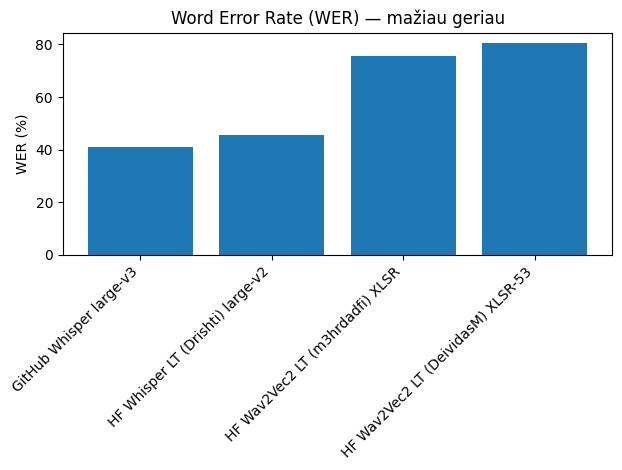

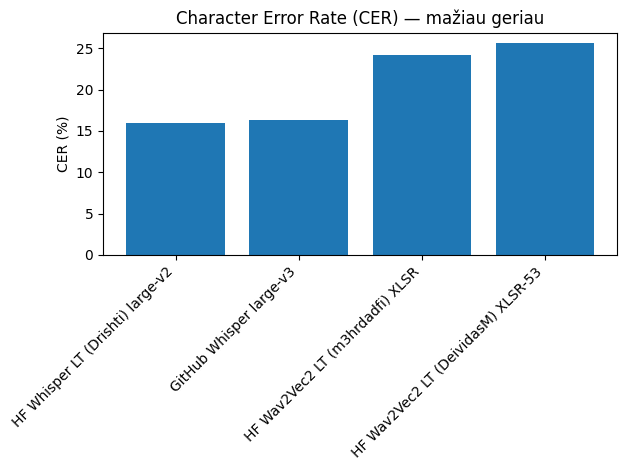

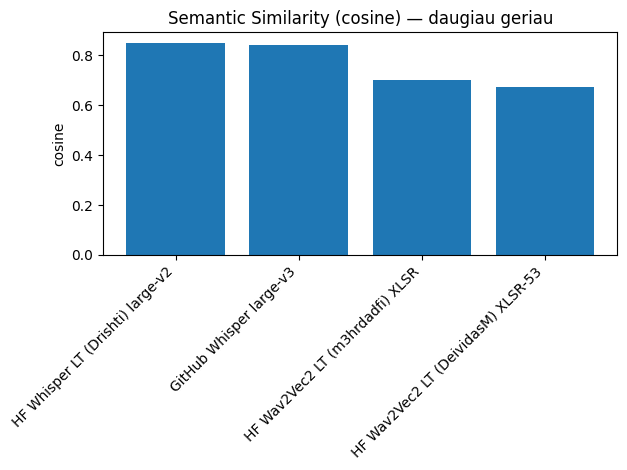

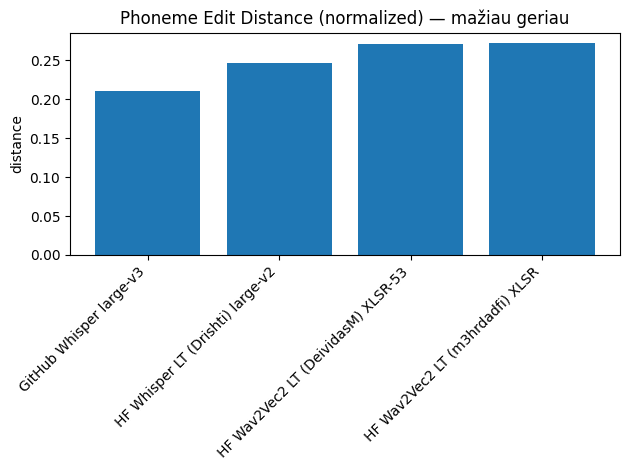

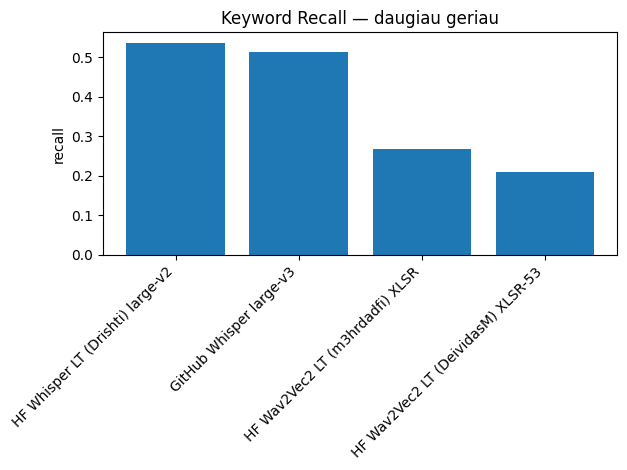

KR_coverage_% = kiek segmentų turėjo bent 1 keyword pagal taisykles.


,model,KR_avg,KR_coverage_%
0,GitHub Whisper large-v3,0.514875,92.5698
1,HF Whisper LT (Drishti) large-v2,0.536723,92.5698
2,HF Wav2Vec2 LT (m3hrdadfi) XLSR,0.267939,92.5698
3,HF Wav2Vec2 LT (DeividasM) XLSR-53,0.211096,92.5698


In [11]:
# Bar charts (WER, CER, SEM, PED, KR)

def barplot(metric, title, ylabel, sort_asc=True):
    dfp = sum_df.sort_values(metric, ascending=sort_asc).reset_index(drop=True)
    plt.figure()
    plt.bar(dfp["model"], dfp[metric])
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

barplot("WER_%",   "Word Error Rate (WER) — mažiau geriau", "WER (%)", sort_asc=True)
barplot("CER_%",   "Character Error Rate (CER) — mažiau geriau", "CER (%)", sort_asc=True)
barplot("SEM_avg", "Semantic Similarity (cosine) — daugiau geriau", "cosine", sort_asc=False)
barplot("PED_avg", "Phoneme Edit Distance (normalized) — mažiau geriau", "distance", sort_asc=True)
barplot("KR_avg",  "Keyword Recall — daugiau geriau", "recall", sort_asc=False)

print("KR_coverage_% = kiek segmentų turėjo bent 1 keyword pagal taisykles.")
display(sum_df[["model", "KR_avg", "KR_coverage_%"]])